## Imports

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import re
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Processing data

In [2]:
df = pd.read_csv("resale_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223415 entries, 0 to 223414
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   month                223415 non-null  object 
 1   town                 223415 non-null  object 
 2   flat_type            223415 non-null  object 
 3   block                223415 non-null  object 
 4   street_name          223415 non-null  object 
 5   storey_range         223415 non-null  object 
 6   floor_area_sqm       223415 non-null  float64
 7   flat_model           223415 non-null  object 
 8   lease_commence_date  223415 non-null  int64  
 9   remaining_lease      223415 non-null  object 
 10  resale_price         223415 non-null  float64
dtypes: float64(2), int64(1), object(8)
memory usage: 18.7+ MB


In [3]:
df["month"] = pd.to_datetime(df["month"], format="%Y-%m")
def lease_to_years(s):
    if pd.isna(s):
        return np.nan
    
    s = str(s).lower()
    
    years = re.search(r"(\d+)\s*year", s)
    months = re.search(r"(\d+)\s*month", s)
    
    y = int(years.group(1)) if years else 0
    m = int(months.group(1)) if months else 0
    
    return y + m/12

df["remaining_lease_years"] = df["remaining_lease"].apply(lease_to_years)

## Baseline Linear Regression

To predict the resale price

In [4]:
df["log_price"] = np.log(df["resale_price"])

#features
X = df[["town","flat_type","storey_range","floor_area_sqm", "remaining_lease_years","flat_model"]].copy()

#predictors
y = df[["log_price"]]

cat_cols = ["town","flat_type","storey_range"]
num_cols = ["floor_area_sqm", "remaining_lease_years"]

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

model = Pipeline(steps=[("preprocess", preprocess),("regressor", LinearRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)
pred = model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 0.168386424188229
RMSE: 0.19974124894350948


## Baseline model

What are the main drivers of price using simple OLS regression

In [5]:
model = smf.ols(
    "log_price ~ floor_area_sqm + C(flat_type) + remaining_lease_years",
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.464
Model:                            OLS   Adj. R-squared:                  0.464
Method:                 Least Squares   F-statistic:                 2.416e+04
Date:                Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:27:17   Log-Likelihood:                -11006.
No. Observations:              223415   AIC:                         2.203e+04
Df Residuals:                  223406   BIC:                         2.212e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

Simple interpretation

A 2-room flat is associated with a 0.0991 higher log(price) than a 1-room flat (the baseline category), holding all other variables constant. OR
A 2-room flat is associated with about 10.4% higher resale price compared to a 1-room flat, holding other variables constant.

## Model + all other factors

Helps me understand if towns and other supporting features are significant predictors of price

In [6]:
model = smf.ols(
    "log_price ~ floor_area_sqm + C(town) + C(flat_type) + C(storey_range) + remaining_lease_years",
    data=df
).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     9119.
Date:                Tue, 20 Jan 2026   Prob (F-statistic):               0.00
Time:                        15:27:18   Log-Likelihood:                 42103.
No. Observations:              223415   AIC:                        -8.411e+04
Df Residuals:                  223365   BIC:                        -8.359e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                                       coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercep

## XGBoost

In [7]:
from xgboost import XGBRegressor

In [8]:
xgb_model = Pipeline([("preprocess",preprocess),("regressor",XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42))])

xgb_model.fit(X_train,y_train)
pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, pred)
rmse = np.sqrt(mean_squared_error(y_test, pred))
print("XGB MAE:", mae)
print("XGB RMSE:", rmse)

XGB MAE: 0.10425648093223572
XGB RMSE: 0.13310034497839346


Compared to linear regression, the XGBoost model reduced the typical prediction error from ~18% to ~11%, and reduced large mistakes from ~22% to ~14%.

In [ ]:
sample = X_test.copy()
sample["actual_price"] = np.exp(y_test.values)
sample["pred_price"] = np.exp(pred)
sample["abs_error"] = abs(sample["actual_price"] - sample["pred_price"])
sample["pct_error"] = sample["abs_error"] / sample["actual_price"]

sample.head(10)


,town,flat_type,storey_range,floor_area_sqm,remaining_lease_years,flat_model,actual_price,pred_price,abs_error,pct_error
305,CENTRAL AREA,3 ROOM,16 TO 18,68.0,61.166667,Improved,470000.0,496173.65625,26173.65625,0.055689
203794,CHOA CHU KANG,EXECUTIVE,07 TO 09,149.0,69.833333,Apartment,848000.0,708015.68750,139984.31250,0.165076
19284,BUKIT PANJANG,EXECUTIVE,22 TO 24,127.0,84.416667,Premium Apartment,748000.0,625175.12500,122824.87500,0.164204
143595,ANG MO KIO,3 ROOM,01 TO 03,68.0,56.500000,New Generation,350000.0,325042.56250,24957.43750,0.071307
26786,BUKIT MERAH,5 ROOM,01 TO 03,115.0,86.500000,Improved,800800.0,768558.43750,32241.56250,0.040262
90650,CHOA CHU KANG,4 ROOM,10 TO 12,93.0,94.416667,Model A,458888.0,492621.43750,33733.43750,0.073511
73223,BEDOK,5 ROOM,01 TO 03,122.0,64.416667,Improved,510000.0,518565.71875,8565.71875,0.016796
166584,WOODLANDS,4 ROOM,07 TO 09,103.0,60.583333,Model A,475000.0,423916.43750,51083.56250,0.107544
186729,QUEENSTOWN,3 ROOM,19 TO 21,65.0,48.500000,Improved,515388.0,455521.71875,59866.28125,0.116158
190374,TAMPINES,4 ROOM,10 TO 12,91.0,60.250000,New Generation,555000.0,515456.50000,39543.50000,0.071250


## SHAP Explanation

We use SHAP since XGBoost is non-linear, cannot simply use coefficients like OLS. SHAP tells us the feature importance

In [14]:
import shap

# 1) pull out fitted steps
pre = xgb_model.named_steps["preprocess"]
reg = xgb_model.named_steps["regressor"]

# 2) transform features (same as training)
X_test_enc = pre.transform(X_test)

# 3) get feature names after encoding
feature_names = pre.get_feature_names_out()

# print(feature_names)

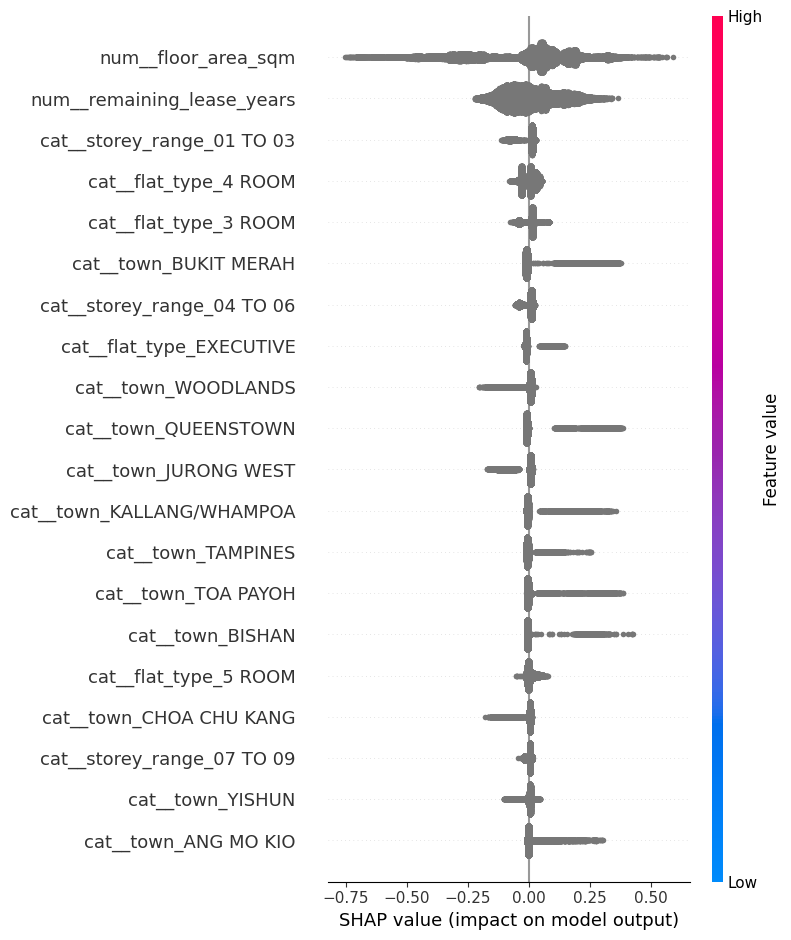

In [11]:
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test_enc)

shap.summary_plot(shap_values, X_test_enc, feature_names=feature_names)

We now can undertsand the key drivers of predicted resale price.
The model is most sensitive to floor area and remaining lease. Larger flats and longer remaining leases consistently push predicted price higher. Storey range and flat type have secondary effects, and town captures location premiums.

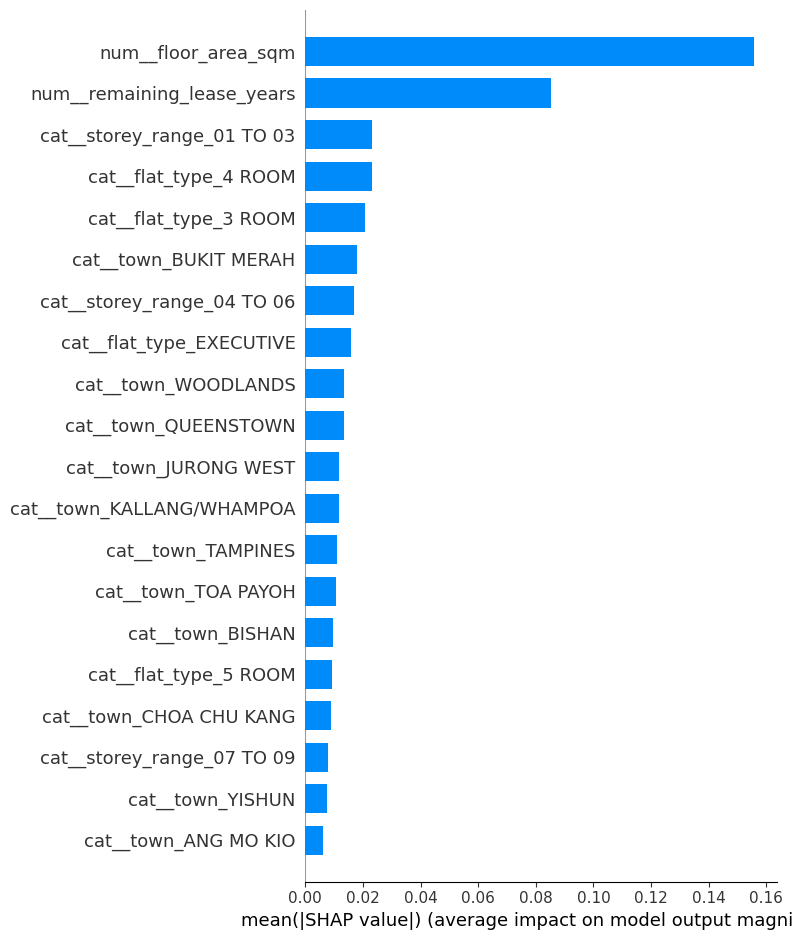

In [12]:
shap.summary_plot(shap_values, X_test_enc, feature_names=feature_names, plot_type="bar")